In [55]:
from __future__ import print_function
import argparse
import numpy as np
import os
import shutil
import time
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
from benedict import BeneDict
import copy
import seaborn as sns
from scipy.stats.stats import pearsonr
from scipy.stats import linregress
plt.style.use('seaborn-muted')
plt.style.use('seaborn-talk')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# Custom code
import utils as U
from generate_graph_structure import create_adjacency_matrix, flatten_correlation, granger_causality, behavioral_prediction_correlation_wrapper
from dataloading import read_from_files, filter_data, normalize_by_behavior_report_type

In [57]:
savenames = ['BAYLORGC4_2018_03_20.mat',
             'BAYLORGC4_2018_03_21.mat',
             'BAYLORGC4_2018_03_22.mat',
             'BAYLORGC4_2018_03_23.mat',
#              'BAYLORGC4_2018_03_25.mat',
#              'BAYLORGC12_2018_04_03.mat',
#              'BAYLORGC12_2018_04_04.mat',
#              'BAYLORGC12_2018_04_05.mat',
#              'BAYLORGC12_2018_04_06.mat',
#              'BAYLORGC13_2018_04_23.mat',
#              'BAYLORGC13_2018_04_24.mat',
#              'BAYLORGC13_2018_04_25.mat',
#              'BAYLORGC15_2018_05_07.mat',
#              'BAYLORGC15_2018_05_08.mat',
#              'BAYLORGC15_2018_05_09.mat',
#              'BAYLORGC15_2018_05_10.mat',
#              'BAYLORGC15_2018_05_11.mat',
#              'BAYLORGC17_2018_06_08.mat',
#              'BAYLORGC17_2018_06_11.mat',
#              'BAYLORGC18_2018_05_31.mat',
#              'BAYLORGC19_2018_06_20.mat',
#              'BAYLORGC19_2018_06_21.mat',
#              'BAYLORGC19_2018_06_22.mat'
            ]
# !!!!! Change here to generate graphs for different sessions
# all_file_to_read = [savenames[0]]
all_file_to_read = savenames
print('Reading files {}'.format(', '.join(all_file_to_read)))
all_data = read_from_files(all_file_to_read)

Reading files BAYLORGC4_2018_03_20.mat, BAYLORGC4_2018_03_21.mat, BAYLORGC4_2018_03_22.mat, BAYLORGC4_2018_03_23.mat


In [58]:
# !!!!! Change here to generate graphs for different perturbation conditions

# The type of perturbation enforced
## 0: no 
## 1: perturbation of left
## 2: perturbation of right
## 3: perturbation of both
perturbation_type = 3 # or 1, 2, or 3
perturbation_type_names = ['No Perturbation', 'Left Perturbation', 'Right Perturbation', 'Bilateral Perturbation']
perturbation_type_name = perturbation_type_names[perturbation_type]

# Only look at success trials when True
# When there is bilarteral perturbation, the mice cannot act correctly, so we need to look at unsuccessful trials
enforce_task_success = (perturbation_type != 3)
# When there is no perturbation
if perturbation_type == 0:
    time_window = (22,37)
else:
# when there are perturbations, we use neural signals after the perturbations have ended
    time_window = (31,37)

In [59]:
## Filter all the data depending on what we want
all_data_filtered = [filter_data(data,
                                 perturbation_type=perturbation_type,
                                 enforce_task_success=enforce_task_success,
                                 time_window=time_window) for data in all_data]

if perturbation_type != 3:
    all_data_filtered = [normalize_by_behavior_report_type(data) for data in all_data_filtered]

In [60]:
def binned(values, value_range):
    counts = np.array([0 for x in value_range])
    for value in values:
        for i in range(len(value_range)):
            if value > value_range[i]:
                counts[i] += 1
    counts = counts[:-1] - counts[1:]
    return counts

In [61]:
def plot_edge_weight(mat, neuron_locations, method_name, perturbation_type_name, session_name, eps=0.05):
    same_side = []
    different_side = []
    for i in range(len(mat)):
        for j in range(len(mat)):
            if i == j:
                continue
            if neuron_locations[i] == neuron_locations[j]:
                same_side.append(mat[i,j])
            else:
                different_side.append(mat[i,j])
    value_range = np.linspace(np.min(mat) - eps, np.max(mat) + eps, 10)
    ss_count = binned(same_side, value_range)
    ds_count = binned(different_side, value_range)
    x = (value_range[:-1] + value_range[1:]) / 2
    f = plt.figure()
    plt.plot(x, ss_count, label='Same Side')
    plt.plot(x, ds_count, label='Different Side')
    plt.legend()
    plt.xlabel('Edge Weight')
    plt.ylabel('Count')
    plt.title('Edge Weight Distribution: {} Network\n ( {} Trials)'.format(method_name, perturbation_type_name), fontsize=12)
    #plt.tight_layout()
    f.savefig('{}-{}.pdf'.format(method_name, perturbation_type_name, session_name))
    plt.show()

In [62]:
eps = 0.05
neuron_locations = all_data_filtered[0].neuron_locations
session_name = all_data_filtered[0].name
methods = [flatten_correlation, granger_causality, behavioral_prediction_correlation_wrapper(all_data_filtered[0]['behavior_report_type'])]
mats = [create_adjacency_matrix(all_data_filtered[0], edge_weight_func=x) for x in methods]
method_names = ['Correlation', 'Causality', 'Behavioral Prediction Similarity']



N, T, K:  42 6 84
(84,)
N, T, K:  42 6 84
(84,)
N, T, K:  42 6 84
(84,)


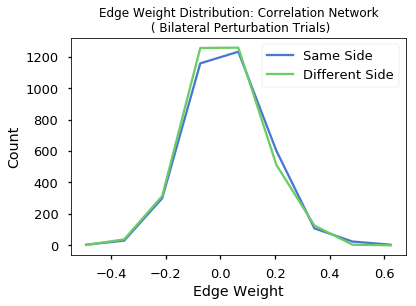

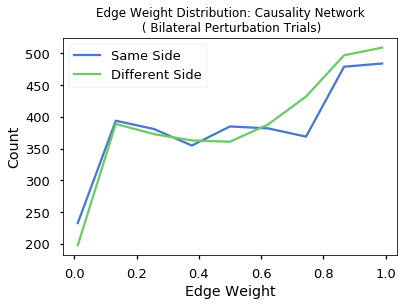

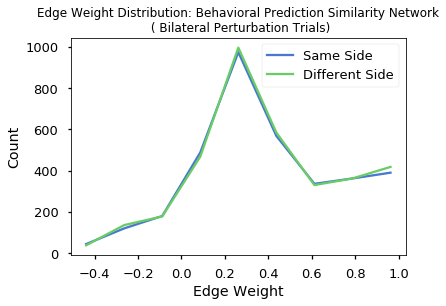

In [63]:

# mat = mat_correlation
# neuron_locations = a.neuron_locations
# method_name = 'Correlation'

for i in range(len(mats)):
    mat = mats[i]
    method_name = method_names[i]
    plot_edge_weight(mat, neuron_locations, method_name, perturbation_type_name, session_name)